In [398]:
#dane do pobrania z https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [400]:
from functools import partial
from hyperopt import fmin, STATUS_OK, hp, Trials, tpe

In [401]:
#nazwanie kolumn
df = pd.read_csv('car.data', names=('buying','maint', 'doors', 'persons', 'lug_boot', 'safety', 'class_val'))

In [402]:
#podgląd danych
df.head()

,buying,maint,doors,persons,lug_boot,safety,class_val
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [403]:
df.describe()

,buying,maint,doors,persons,lug_boot,safety,class_val
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,4,more,big,low,unacc
freq,432,432,432,576,576,576,1210


In [404]:
df.dtypes

buying       object
maint        object
doors        object
persons      object
lug_boot     object
safety       object
class_val    object
dtype: object

In [405]:
df.isna().sum()

buying       0
maint        0
doors        0
persons      0
lug_boot     0
safety       0
class_val    0
dtype: int64

In [406]:
df.nunique()

buying       4
maint        4
doors        4
persons      3
lug_boot     3
safety       3
class_val    4
dtype: int64

In [407]:
for col in df.columns:
    print(col, df[col].unique())

buying ['vhigh' 'high' 'med' 'low']
maint ['vhigh' 'high' 'med' 'low']
doors ['2' '3' '4' '5more']
persons ['2' '4' 'more']
lug_boot ['small' 'med' 'big']
safety ['low' 'med' 'high']
class_val ['unacc' 'acc' 'vgood' 'good']


In [408]:
oryg_columns = df.columns.tolist()

In [409]:
#faktoryzacja
for col in df.columns:
    df[f'cat_{col}'] = df[col].factorize()[0]

In [410]:
df

,buying,maint,doors,persons,lug_boot,safety,class_val,cat_buying,cat_maint,cat_doors,cat_persons,cat_lug_boot,cat_safety,cat_class_val
0,vhigh,vhigh,2,2,small,low,unacc,0,0,0,0,0,0,0
1,vhigh,vhigh,2,2,small,med,unacc,0,0,0,0,0,1,0
2,vhigh,vhigh,2,2,small,high,unacc,0,0,0,0,0,2,0
3,vhigh,vhigh,2,2,med,low,unacc,0,0,0,0,1,0,0
4,vhigh,vhigh,2,2,med,med,unacc,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good,3,3,3,2,1,1,3
1724,low,low,5more,more,med,high,vgood,3,3,3,2,1,2,2
1725,low,low,5more,more,big,low,unacc,3,3,3,2,2,0,0
1726,low,low,5more,more,big,med,good,3,3,3,2,2,1,3


In [411]:
def legend(col_name, number):
    main_dict = dict()
    for col in oryg_columns:
        uni = df[col].unique()
        nums = list(range(len(uni)))
        main_dict[col] = dict(zip(nums, uni))
    
    if col_name.startswith('cat_'):
        col_name = col_name[4:]
    return main_dict[col_name][number]

In [412]:
legend('buying',0)

'vhigh'

In [413]:
feats = [col for col in df.columns if col.startswith('cat_')]
if 'cat_class_val' in feats: feats.remove('cat_class_val')

In [414]:
X = df[feats].values
y = df.cat_class_val.values

array([0, 0, 0, ..., 0, 3, 2], dtype=int64)

In [415]:
from sklearn.model_selection import train_test_split

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [417]:
from sklearn.metrics import accuracy_score

In [418]:
#podstawowy model z przykładowymi parametrami
params = {
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': 10,
 'subsample': 0.8,
 'n_estimators': 50}

In [419]:
basic_model = xgboost.XGBClassifier(**params)

In [420]:
basic_model.fit(X_train, y_train)
y_pred = basic_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9826589595375722


In [421]:
from sklearn.model_selection import KFold

In [422]:
#walidacja krzyżowa modelu podstawowego
cv = KFold(n_splits=5)
score_list = []
for train_index, test_index in cv.split(X,y):
    X_train_val, y_train_val = X[train_index], y[train_index]
    X_test_val, y_test_val = X[test_index], y[test_index]

    basic_model.fit(X_train_val, y_train_val)
    y_pred_val = basic_model.predict(X_test_val)
    score = accuracy_score(y_test_val, y_pred_val)
    score_list.append(score)
print(score_list)

[0.8959537572254336, 0.8930635838150289, 0.9913294797687862, 0.7855072463768116, 0.8608695652173913]


In [423]:
#średni wynik walidacji krzyżowej modelu podstawowego
np.round(np.mean(score_list),3)

0.885

In [424]:
#Hyperopt + XGBoost

In [425]:
def objective(space):
    params = { 'colsample_bytree': space['colsample_bytree'], 
    'learning_rate': space['learning_rate'],
    'max_depth': int(space['max_depth']),
    'subsample': space['subsample'],
    'n_estimators': int(space['n_estimators'])
    }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    
    return {'loss': score, 'status': STATUS_OK}

In [426]:
space = { 'colsample_bytree': hp.uniform('x_colsample_by_tree', 0.6,1.0), 
    'learning_rate': hp.uniform('x_learning_rate', 0.03, 0.3),
    'max_depth': hp.quniform('x_max_depth',4,20,1),
    'subsample': hp.uniform('x_subsample',0.7,1.0),
    'n_estimators': hp.quniform('x_n_estimators',5,100,1)
    }

In [427]:
trials = Trials()
best_params = fmin(fn = objective, space = space, algo=partial(tpe.suggest, n_startup_jobs = 1), max_evals=30, trials=trials)

100%|██████████| 30/30 [00:04<00:00,  6.60trial/s, best loss: 0.8323699421965318]


In [428]:
best_params

{'x_colsample_by_tree': 0.6446767394712631,
 'x_learning_rate': 0.06524644873775519,
 'x_max_depth': 14.0,
 'x_n_estimators': 7.0,
 'x_subsample': 0.7730687797727485}

In [429]:
best_model = xgboost.XGBClassifier(**best_params)

In [430]:
#walidacja krzyżowa najlepszego modelu
cv = KFold(n_splits=5)
score_list = []
for train_index, test_index in cv.split(X,y):
    X_train_val, y_train_val = X[train_index], y[train_index]
    X_test_val, y_test_val = X[test_index], y[test_index]

    best_model.fit(X_train_val, y_train_val)
    y_pred_val = best_model.predict(X_test_val)
    score = accuracy_score(y_test_val, y_pred_val)
    score_list.append(score)
print(score_list)

[0.8959537572254336, 0.8959537572254336, 0.9913294797687862, 0.7855072463768116, 0.8666666666666667]


In [431]:
#średni wynik walidacji krzyżowej modelu podstawowego
np.round(np.mean(score_list),3)

0.887

In [432]:
import scikitplot as sklplot

In [433]:
#Ważność cech

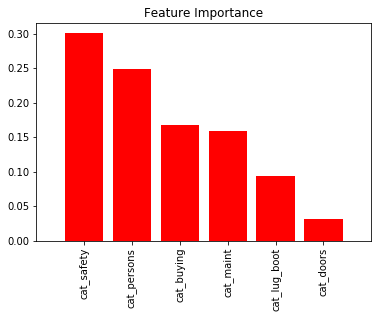

In [434]:
sklplot.estimators.plot_feature_importances(best_model, feature_names=feats, x_tick_rotation=90)